In [4]:
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import cv2
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

### Read X-Ray images

In [2]:
images = glob.glob('dataset/*/*/*.png')
len(images)

112120

In [18]:
images[0]

'dataset/images_006/images/00013436_003.png'

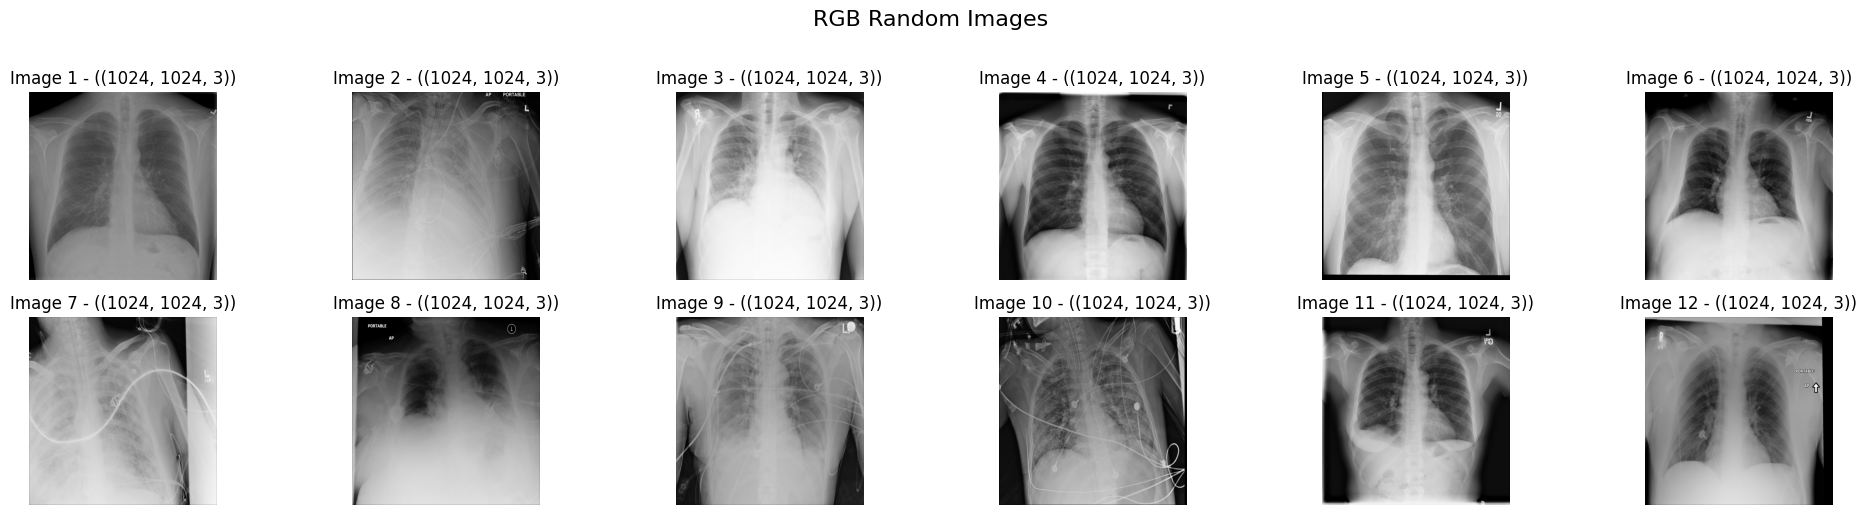

In [32]:
# img = cv2.imread(images[10])
fig, axs = plt.subplots(2, 6, figsize=(20, 5))

for i in range(12):
    row = i // 6
    col = i % 6
    idx = random.randint(0, len(images) - 1)
    img = cv2.imread(images[idx])             
    axs[row, col].imshow(img) 
    axs[row, col].axis('off')   
    axs[row, col].set_title(f"Image {i+1} - ({img.shape})")

plt.suptitle('RGB Random Images', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

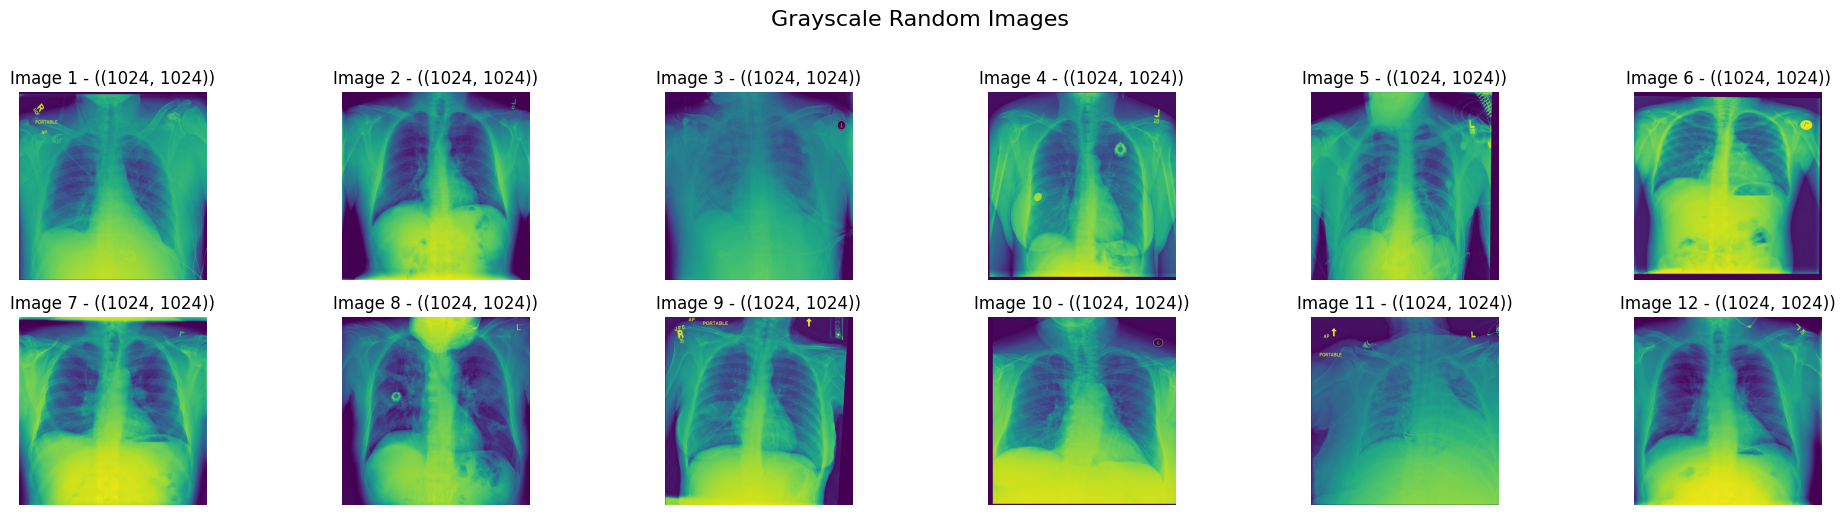

In [33]:
fig, axs = plt.subplots(2, 6, figsize=(20, 5)) 

for i in range(12):
    row = i // 6
    col = i % 6
    idx = random.randint(0, len(images) - 1)
    img = cv2.imread(images[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          
    axs[row, col].imshow(img)
    axs[row, col].axis('off')   
    axs[row, col].set_title(f"Image {i+1} - ({img.shape})")

plt.suptitle('Grayscale Random Images', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Read Metadata

In [ ]:
df = pd.read_csv('dataset/Data_Entry_2017.csv')

df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0          2749                        0.143  0.143          NaN  
1          2729                        0.143  0.143          NaN  
2          2048                        0.168  0.168          NaN  
3          2048                        0.171  0.171          NaN  
4          2991                        0.143  0.143          NaN  
...         ...                          ...    ...          ...  
112115     2500                        0.168  0.168          NaN  
112116     2500                        0.168  0.168          NaN  
112117     2500                        0.168  0.168          NaN  
112118     2500                        0.168  0.168          NaN  
112119     2500                        0.171  0.171          NaN  

[112120 rows x 12 columns]

### Exploratory Data Analysis (EDA)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [22]:
df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

In [23]:
df.shape

(112120, 12)

In [88]:
df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [34]:
labels = df['Finding Labels'].unique().tolist()

labels

['Cardiomegaly',
 'Cardiomegaly|Emphysema',
 'Cardiomegaly|Effusion',
 'No Finding',
 'Hernia',
 'Hernia|Infiltration',
 'Mass|Nodule',
 'Infiltration',
 'Effusion|Infiltration',
 'Nodule',
 'Emphysema',
 'Effusion',
 'Atelectasis',
 'Effusion|Mass',
 'Emphysema|Pneumothorax',
 'Pleural_Thickening',
 'Effusion|Emphysema|Infiltration|Pneumothorax',
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
 'Effusion|Pneumonia|Pneumothorax',
 'Pneumothorax',
 'Effusion|Infiltration|Pneumothorax',
 'Infiltration|Mass',
 'Infiltration|Mass|Pneumothorax',
 'Mass',
 'Cardiomegaly|Infiltration|Mass|Nodule',
 'Cardiomegaly|Effusion|Emphysema|Mass',
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
 'Emphysema|Mass',
 'Emphysema|Mass|Pneumothorax',
 'Atelectasis|Pneumothorax',
 'Cardiomegaly|Emphysema|Pneumothorax',
 'Mass|Pleural_Thickening',
 'Cardiomegaly|Mass|Pleural_Thickening',
 'Effusion|Infiltration|Nodule',
 'Atelectasis|Effusion|Pleural_Thickening',
 'Fibrosis|Infiltration',
 

In [35]:
len(labels)

836

In [36]:
# Select 6 diseases to from the dataset
classes_dict = {'Pneumonia':0, 'Effusion':1, 'Nodule':2, 'Fibrosis':3, 'Mass':4, 'No Finding':5}

classes = classes_dict.keys()

In [37]:
def count_dataframe(df, classes):
    total_data = 0

    for class_name in classes:
        dx = df[df['Finding Labels'] == class_name].shape
        print(f'{class_name} \t=>\t {dx[0]}')
        total_data += dx[0]

    print(f'\nThe new dataset contains {total_data} samples 📁')

count_dataframe(df, classes)
print('\nThe data appears to be imbalanced ⚖️ — some classes have significantly more samples than others 📊')

Pneumonia 	=>	 322
Effusion 	=>	 3955
Nodule 	=>	 2705
Fibrosis 	=>	 727
Mass 	=>	 2139
No Finding 	=>	 60361

The new dataset contains 70209 samples 📁

The data appears to be imbalanced ⚖️ — some classes have significantly more samples than others 📊


In [38]:
filter_df = df[df['Finding Labels'].isin(classes)].reset_index(drop=True).copy()

filter_df

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0      00000002_000.png     No Finding            0           2           81   
1      00000005_000.png     No Finding            0           5           69   
2      00000005_001.png     No Finding            1           5           69   
3      00000005_002.png     No Finding            2           5           69   
4      00000005_003.png     No Finding            3           5           69   
...                 ...            ...          ...         ...          ...   
70204  00030801_000.png     No Finding            0       30801           39   
70205  00030802_000.png     No Finding            0       30802           29   
70206  00030803_000.png     No Finding            0       30803           42   
70207  00030804_000.png     No Finding            0       30804           30   
70208  00030805_000.png     No Finding            0       30805           27   

      Patient Gender View Position  OriginalImage[Width  Height]  \
0                  M            PA                 2500     2048   
1                  F            PA                 2048     2500   
2                  F            AP                 2500     2048   
3                  F            AP                 2500     2048   
4                  F            PA                 2992     2991   
...              ...           ...                  ...      ...   
70204              M            PA                 2500     2048   
70205              M            PA                 2048     2500   
70206              F            PA                 2048     2500   
70207              F            PA                 2048     2500   
70208              M            PA                 2048     2500   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                            0.171  0.171          NaN  
1                            0.168  0.168          NaN  
2                            0.168  0.168          NaN  
3                            0.168  0.168          NaN  
4                            0.143  0.143          NaN  
...                            ...    ...          ...  
70204                        0.168  0.168          NaN  
70205                        0.168  0.168          NaN  
70206                        0.168  0.168          NaN  
70207                        0.168  0.168          NaN  
70208                        0.171  0.171          NaN  

[70209 rows x 12 columns]

In [39]:
# Select features for EDA
filter_df = filter_df[['Image Index', 'Patient Age', 'Patient Gender', 'Finding Labels']]

filter_df

Image Index  Patient Age Patient Gender Finding Labels
0      00000002_000.png           81              M     No Finding
1      00000005_000.png           69              F     No Finding
2      00000005_001.png           69              F     No Finding
3      00000005_002.png           69              F     No Finding
4      00000005_003.png           69              F     No Finding
...                 ...          ...            ...            ...
70204  00030801_000.png           39              M     No Finding
70205  00030802_000.png           29              M     No Finding
70206  00030803_000.png           42              F     No Finding
70207  00030804_000.png           30              F     No Finding
70208  00030805_000.png           27              M     No Finding

[70209 rows x 4 columns]

In [40]:
filter_df['Patient Age'].unique()

array([ 81,  69,  70,  82,  73,  75,  61,  60,  62,  57,  56,  71,  77,
        78,  48,  49,  63,  52,  59,  55,  76,  79,  80,  72,  67,  74,
        46,  91,  92,  87,  64,  53,  54,  66,  65,  50,  68,  51,  58,
        83,  33,  42,  25,  31,  47,  94,  89,  90,  40,  85,  45,  30,
        32,  34,  84,  86,  37,  36,  38,  39,  43,  28,  44,  29,  35,
        22,  23,  27,  26,  21,  24,  41,  18,  19,  20,  17,  88,  16,
        13,  14,  11,  12,  15,  93,   9,  10,   8,   6,   4,   5,   7,
         3,   2,   1, 148,  95, 149, 411, 413, 412, 155])

In [41]:
filter_df['Patient Gender'].unique()

array(['M', 'F'], dtype=object)

In [42]:
# Let's group our age for ease of visualization
def age_bin(age):
    if age < 20:
        return '19 down'
    elif 20 <= age < 40:
        return '20-39'
    elif 40 <= age < 60:
        return '40-59'
    elif 60 <= age < 80:
        return '60-79'
    elif 80 <= age < 100:
        return '80-99' 
    else:
        return '100 up'

filter_df['Patient Age'] = filter_df['Patient Age'].map(age_bin)

filter_df

/tmp/ipykernel_642528/254547979.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df['Patient Age'] = filter_df['Patient Age'].map(age_bin)


Image Index Patient Age Patient Gender Finding Labels
0      00000002_000.png       80-99              M     No Finding
1      00000005_000.png       60-79              F     No Finding
2      00000005_001.png       60-79              F     No Finding
3      00000005_002.png       60-79              F     No Finding
4      00000005_003.png       60-79              F     No Finding
...                 ...         ...            ...            ...
70204  00030801_000.png       20-39              M     No Finding
70205  00030802_000.png       20-39              M     No Finding
70206  00030803_000.png       40-59              F     No Finding
70207  00030804_000.png       20-39              F     No Finding
70208  00030805_000.png       20-39              M     No Finding

[70209 rows x 4 columns]

In [43]:
age_filter = filter_df['Patient Age'].value_counts().sort_index()

age_filter

Patient Age
100 up         8
19 down     4368
20-39      18967
40-59      30922
60-79      15330
80-99        614
Name: count, dtype: int64

In [44]:
gender_filter = filter_df['Patient Gender'].value_counts().sort_index() 

gender_filter

Patient Gender
F    30723
M    39486
Name: count, dtype: int64

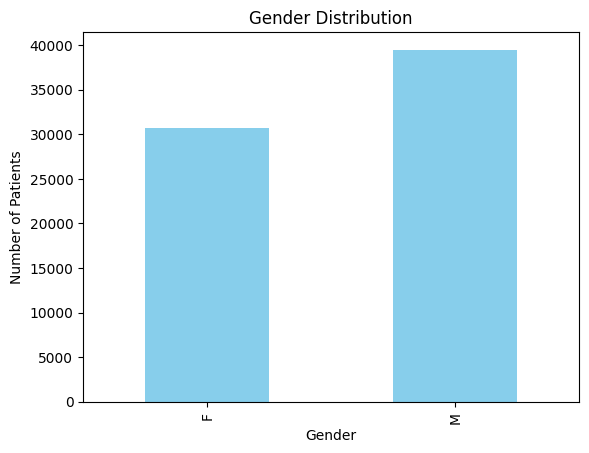

In [45]:
gender_filter.plot(kind='bar', color='skyblue');
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.title('Gender Distribution');

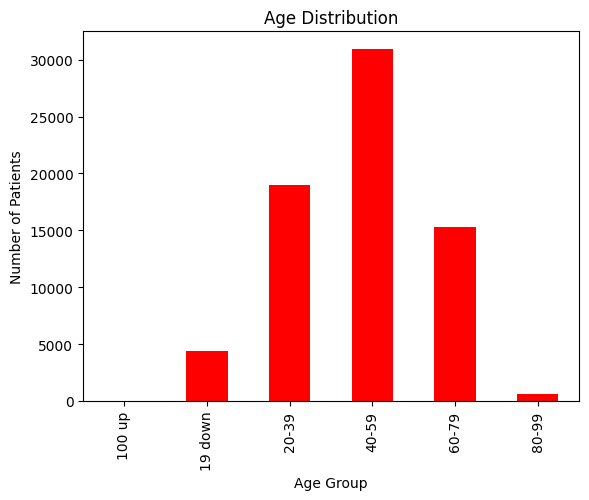

In [46]:
age_filter.plot(kind='bar', color='red');
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.title('Age Distribution');

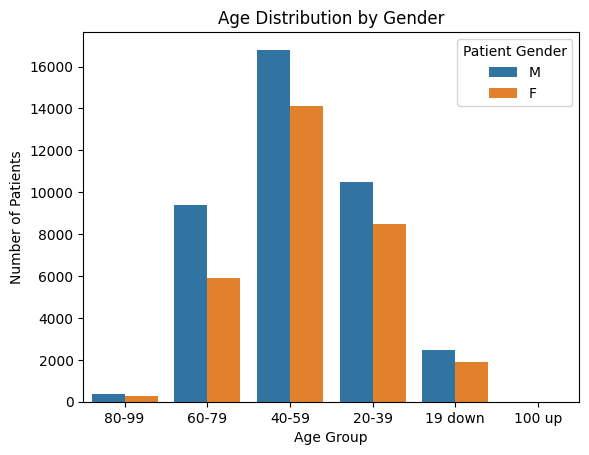

In [47]:
sns.countplot(data=filter_df, x='Patient Age', hue='Patient Gender');
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.title('Age Distribution by Gender');

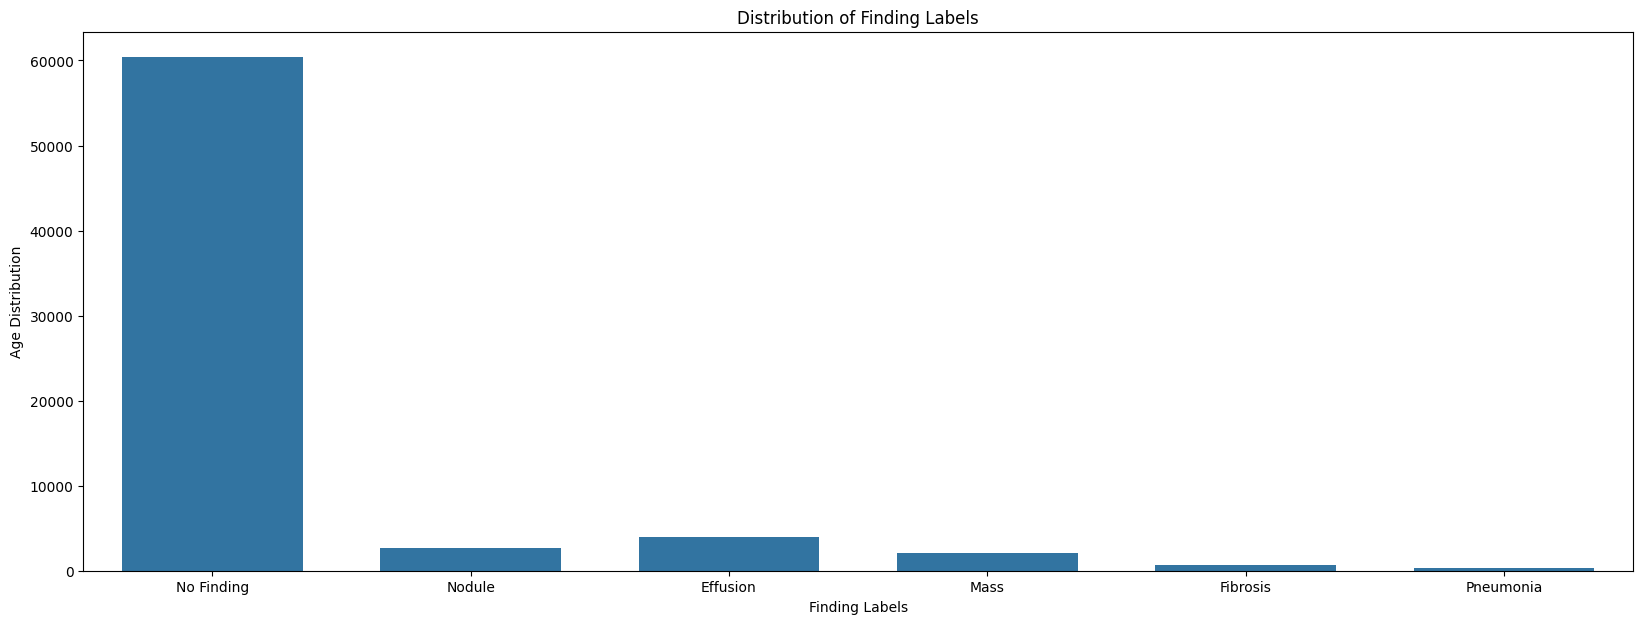

In [102]:
plt.figure(figsize=(20, 7))
sns.countplot(data=filter_df, x='Finding Labels', width=0.7) 
plt.title('Distribution of Finding Labels')
plt.xlabel('Finding Labels')
plt.ylabel('Age Distribution');

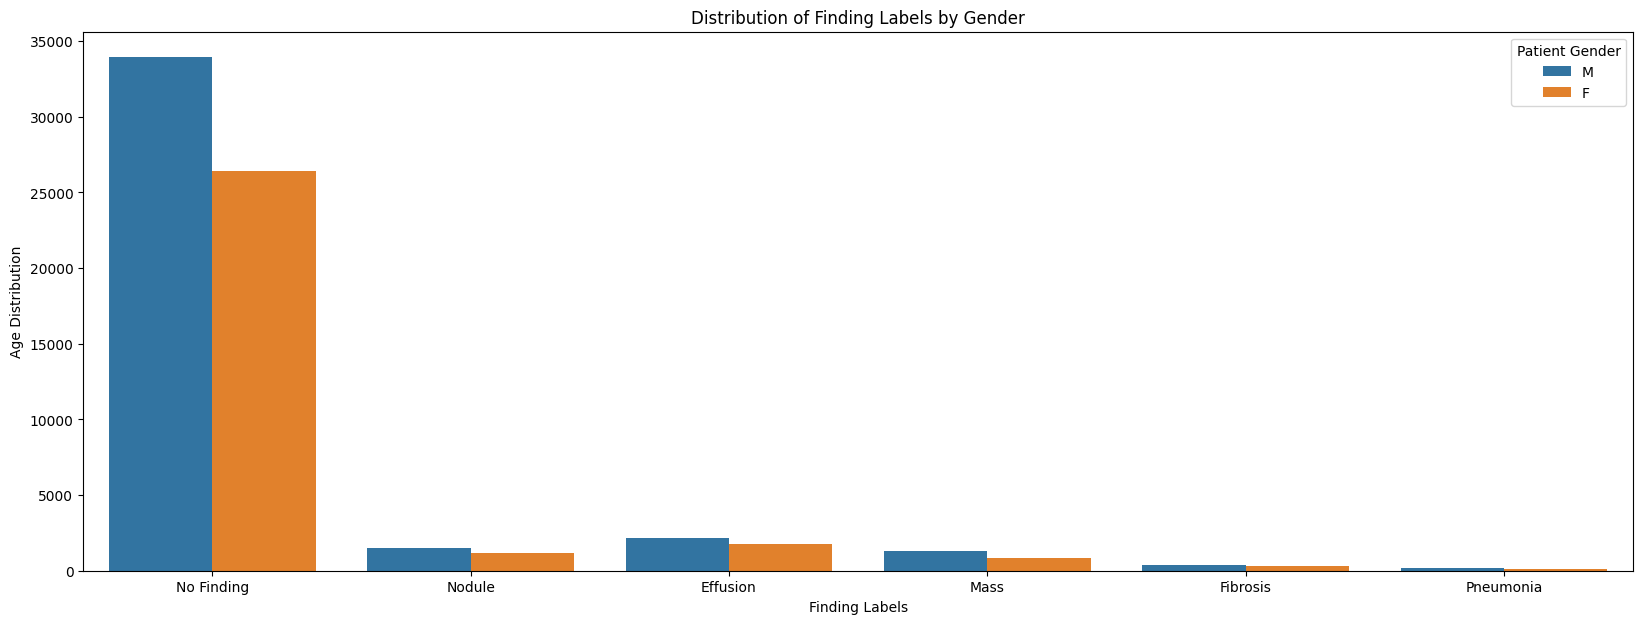

In [103]:
plt.figure(figsize=(20, 7))
sns.countplot(data=filter_df, x='Finding Labels', hue='Patient Gender') 
plt.title('Distribution of Finding Labels by Gender')
plt.xlabel('Finding Labels')
plt.ylabel('Age Distribution');

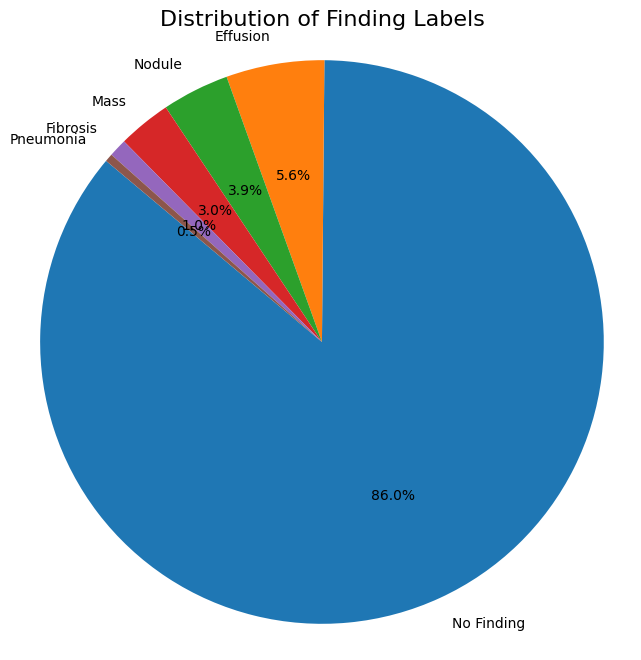

In [104]:
finding_counts = filter_df['Finding Labels'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(finding_counts, labels=finding_counts.index, autopct='%1.1f%%', startangle=140,)
plt.title('Distribution of Finding Labels', fontsize=16)
plt.axis('equal') ;

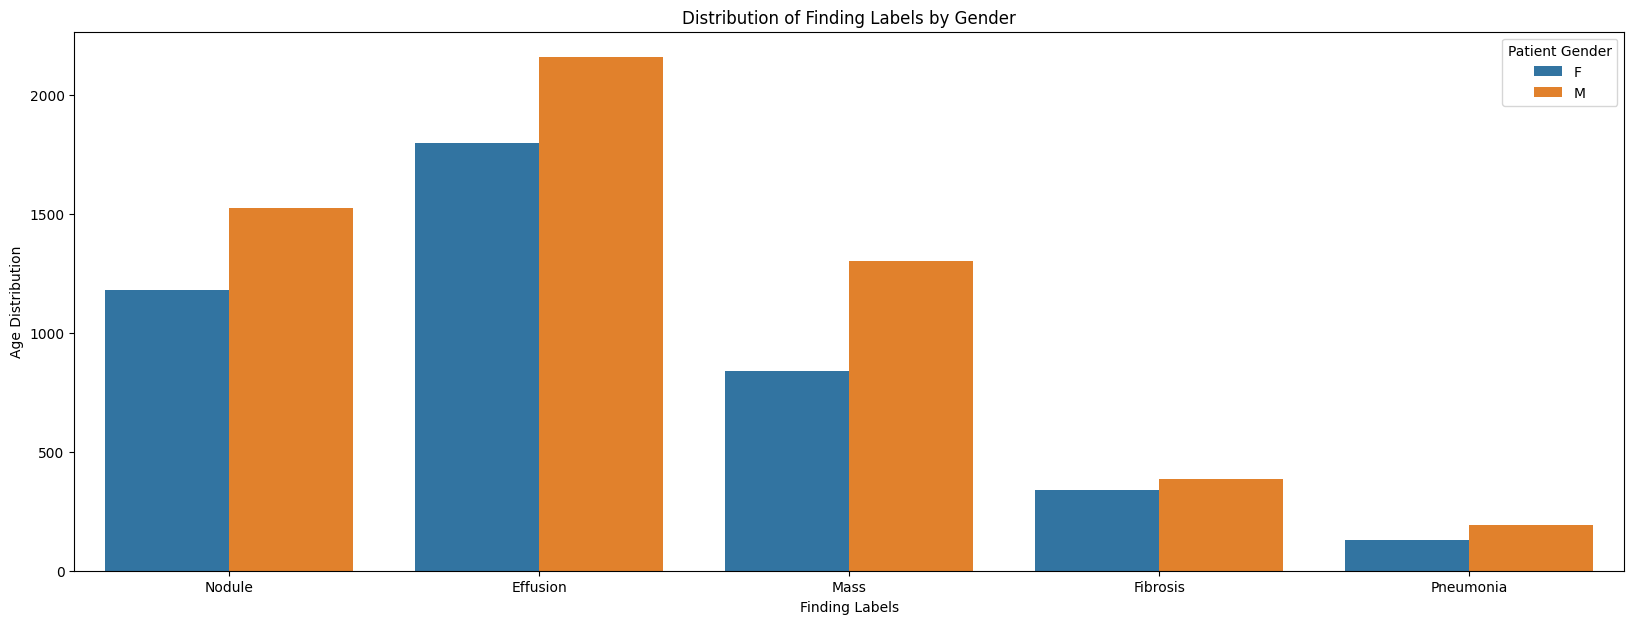

In [ ]:
plt.figure(figsize=(20, 7))
sns.countplot(data=filter_df[filter_df['Finding Labels'] != 'No Finding'], x='Finding Labels', hue='Patient Gender')
plt.title('Distribution of Finding Labels by Gender') 
plt.xlabel('Finding Labels')
plt.ylabel('Age Distribution');

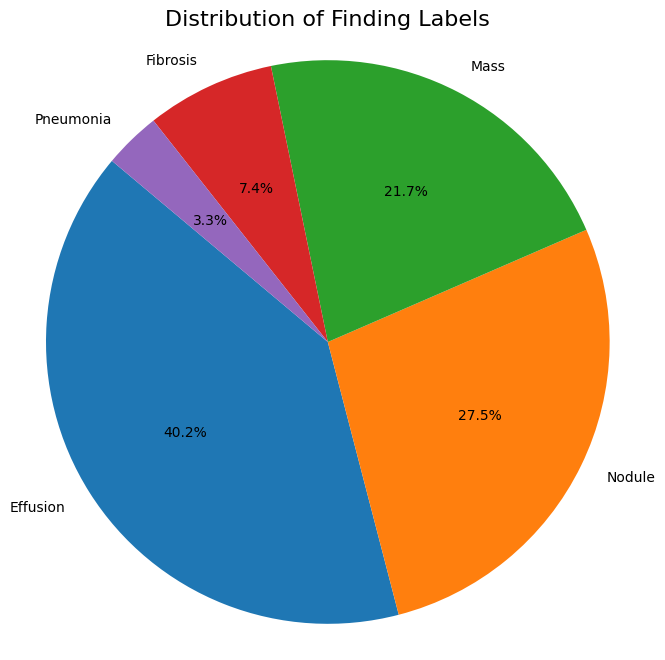

In [106]:
finding_counts = filter_df[filter_df['Finding Labels'] != 'No Finding']['Finding Labels'].value_counts() 

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(finding_counts, labels=finding_counts.index, autopct='%1.1f%%', startangle=140,)
plt.title('Distribution of Finding Labels', fontsize=16)
plt.axis('equal') ;

### ***🧪 Handle Data Imbalance***  
🔻 **Downsample** `No Finding` (majority class)  
🔼 **Upsample** minority classes (less frequent findings)  
🎯 **Goal**: Reduce model bias by balancing the dataset for fairer and more accurate training.


In [107]:
count_dataframe(filter_df, classes)

Pneumonia 	=>	 322
Effusion 	=>	 3955
Nodule 	=>	 2705
Fibrosis 	=>	 727
Mass 	=>	 2139
No Finding 	=>	 60361

The new dataset contains 70209 samples 📁


In [108]:
from sklearn.utils import resample

grouped = filter_df.groupby('Finding Labels')

balanced_list = []

for lable, group in grouped:
    sample_len = len(group)
    if sample_len < 2000:
         sampled = resample(group, replace=True, n_samples=2500, random_state=42)
    elif sample_len > 3000:
        sampled = resample(group, replace=False, n_samples=2500, random_state=42)
    else:
        sampled = group 
    balanced_list.append(sampled)

# Step 3: Combine and shuffle
balanced_df = pd.concat(balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df

Image Index Patient Age Patient Gender Finding Labels
0      00006889_002.png     19 down              M       Fibrosis
1      00016478_002.png       20-39              F     No Finding
2      00028838_000.png       40-59              M     No Finding
3      00019750_031.png       40-59              M      Pneumonia
4      00001023_001.png       40-59              F         Nodule
...                 ...         ...            ...            ...
14839  00004416_000.png       60-79              M           Mass
14840  00017641_003.png       60-79              M      Pneumonia
14841  00006856_005.png       20-39              F           Mass
14842  00007352_012.png       40-59              M       Effusion
14843  00018361_000.png       60-79              F     No Finding

[14844 rows x 4 columns]

In [109]:
count_dataframe(balanced_df, classes)

Pneumonia 	=>	 2500
Effusion 	=>	 2500
Nodule 	=>	 2705
Fibrosis 	=>	 2500
Mass 	=>	 2139
No Finding 	=>	 2500

The new dataset contains 14844 samples 📁


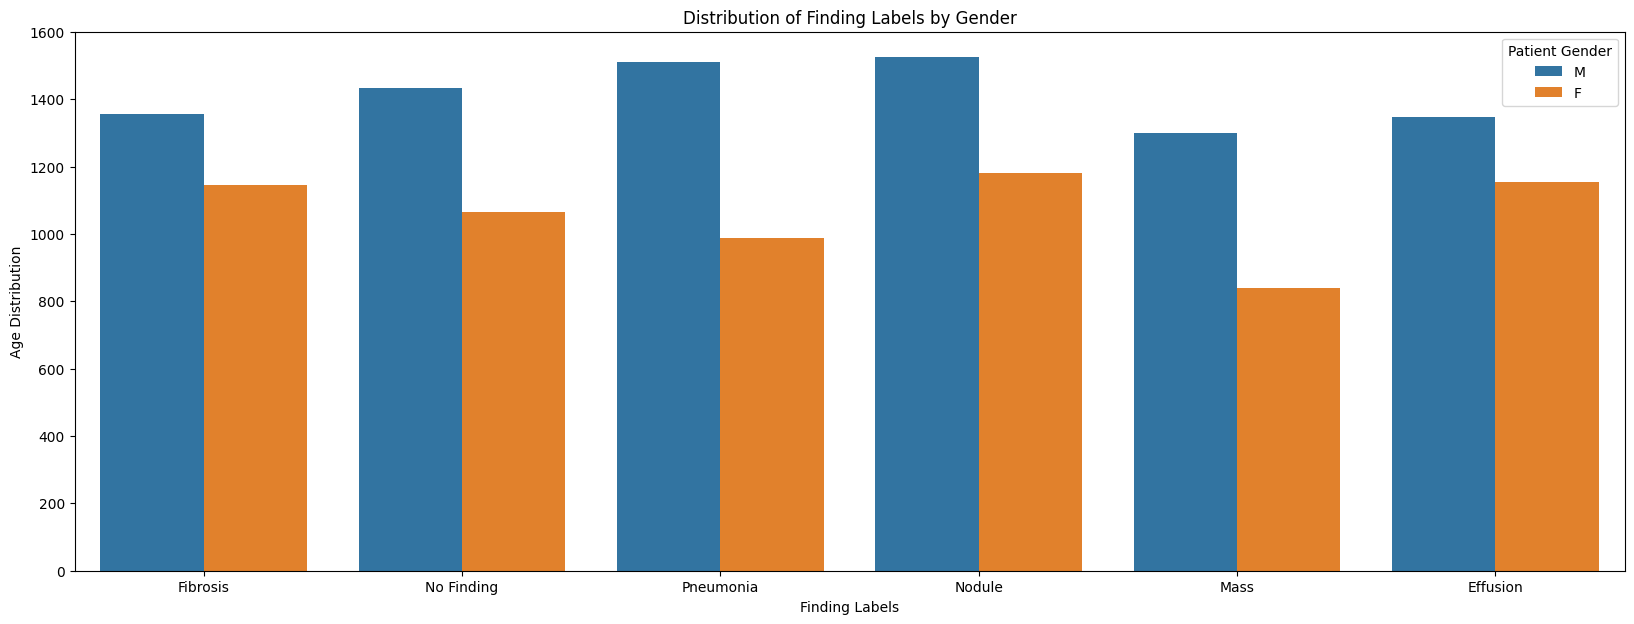

In [110]:
plt.figure(figsize=(20, 7))
sns.countplot(data=balanced_df, x='Finding Labels', hue='Patient Gender') 
plt.title('Distribution of Finding Labels by Gender')
plt.xlabel('Finding Labels')
plt.ylabel('Age Distribution');

### Data Preprocessing

In [111]:
# Encode labels
balanced_df['Labels'] = balanced_df['Finding Labels'].apply(lambda a: classes_dict[a])

balanced_df

Image Index Patient Age Patient Gender Finding Labels  Labels
0      00006889_002.png     19 down              M       Fibrosis       3
1      00016478_002.png       20-39              F     No Finding       5
2      00028838_000.png       40-59              M     No Finding       5
3      00019750_031.png       40-59              M      Pneumonia       0
4      00001023_001.png       40-59              F         Nodule       2
...                 ...         ...            ...            ...     ...
14839  00004416_000.png       60-79              M           Mass       4
14840  00017641_003.png       60-79              M      Pneumonia       0
14841  00006856_005.png       20-39              F           Mass       4
14842  00007352_012.png       40-59              M       Effusion       1
14843  00018361_000.png       60-79              F     No Finding       5

[14844 rows x 5 columns]

In [112]:
image_map = {img.split('/')[-1]: img for img in images}

def update_imgpath(filename):
    return image_map.get(filename, None)

update_imgpath('00010022_000.png')

'dataset/images_005/images/00010022_000.png'

In [113]:
balanced_df['Image Index'] = balanced_df['Image Index'].apply(lambda a: update_imgpath(a))

balanced_df

Image Index Patient Age Patient Gender  \
0      dataset/images_004/images/00006889_002.png     19 down              M   
1      dataset/images_008/images/00016478_002.png       20-39              F   
2      dataset/images_012/images/00028838_000.png       40-59              M   
3      dataset/images_009/images/00019750_031.png       40-59              M   
4      dataset/images_001/images/00001023_001.png       40-59              F   
...                                           ...         ...            ...   
14839  dataset/images_003/images/00004416_000.png       60-79              M   
14840  dataset/images_008/images/00017641_003.png       60-79              M   
14841  dataset/images_004/images/00006856_005.png       20-39              F   
14842  dataset/images_004/images/00007352_012.png       40-59              M   
14843  dataset/images_008/images/00018361_000.png       60-79              F   

      Finding Labels  Labels  
0           Fibrosis       3  
1         No Finding       5  
2         No Finding       5  
3          Pneumonia       0  
4             Nodule       2  
...              ...     ...  
14839           Mass       4  
14840      Pneumonia       0  
14841           Mass       4  
14842       Effusion       1  
14843     No Finding       5  

[14844 rows x 5 columns]

In [114]:
balanced_df.isnull().sum()

Image Index       0
Patient Age       0
Patient Gender    0
Finding Labels    0
Labels            0
dtype: int64

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#### Normalize dataset for Classical ML

In [145]:
w = h = 50
image_size = (w, h)
images, labels = [], []

# Assuming df has 'Image Index' and 'Finding Labels'
for index, row in balanced_df.iterrows():
    img_path = row['Image Index']
    label = row['Labels']
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    
    img = cv2.resize(img, image_size)
    images.append(img.flatten())  # Flatten the image
    labels.append(label)

X = np.array(images)
y = np.array(labels)

In [118]:
y[:10]

array([3, 5, 5, 0, 2, 3, 4, 1, 4, 1])

In [146]:
X[10]

array([11, 11, 11, ..., 72, 72, 97], dtype=uint8)

In [147]:
print(f"🧮 X shape: {X.shape} | 🎯 y shape: {y.shape}")

🧮 X shape: (14844, 2500) | 🎯 y shape: (14844,)


In [148]:
np.save('dataset128d/X.npy', X)
np.save('dataset128d/y.npy', y)
# Load later with: X = np.load('X.npy')

In [149]:
# Split data
def split_1D_data(x, label):
    X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.2, random_state=42)

    X_train = X_train / 255
    X_test = X_test / 255

    return X_train, X_test, y_train, y_test

## Multilayer Perceptron Classification - Implement GridSearch for hyperparameter tuning

In [186]:
X_train, X_test, y_train, y_test = split_1D_data(X, y)

X_train

array([[0.        , 0.        , 0.        , ..., 0.21960784, 0.05882353,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07058824, 0.17254902, 0.08627451, ..., 0.02745098, 0.06666667,
        0.16470588],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27058824, 0.06666667,
        0.        ],
       [0.21568627, 0.        , 0.00784314, ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.83529412, 0.70980392, 0.40392157, ..., 0.06666667, 0.08235294,
        0.08235294]])

In [137]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 15, 20), max_iter=300, random_state=42)

param_grid = {
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32, 64]
}

mlp_grid = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
mlp_result = mlp_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 5.9min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 6.4min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 7.2min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 7.4min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 7.5min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.7min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 8.0min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 8.6min
[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 6.6min
[CV] 

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.5min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 7.6min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 5.4min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.0min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.1min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 7.3min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.7min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.2min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.9min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 4.0min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.3min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.3min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 7.2min
[CV] 

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min
[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 6.3min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 5.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.7min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 7.7min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 3.4min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 4.9min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 5.2min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 9.4min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 5.8min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 8.6min
[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 5.1min
[CV] END activa

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.4min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 7.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.3min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 7.5min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 3.7min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 2.2min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 4.9min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.3min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 4.0min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.7min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.5min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.7min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.6min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.4min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 4.8min
[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.9min
[CV] END activa

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.4min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.7min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 7.4min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.8min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 7.5min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 4.2min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 9.0min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 6.0min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 5.9min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 9.3min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.4min
[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 8.8min
[CV] END activation=relu

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.4min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.4min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.3min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=adam; total time= 4.9min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.0min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=adam; total time= 5.0min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=adam; total time= 4.6min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.1min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.7min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.8min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.8min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.9min
[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=adam; total time= 4.1min
[CV] END activation=relu,

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 4.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=10.3min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=10.6min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 8.1min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 6.2min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.3min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 8.5min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 9.3min
[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time= 4.8min
[CV] END

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.3min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 3.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.4min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 6.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.2min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.6min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 5.4min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=12.0min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.8min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 5.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.8min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.9min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.5min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.7min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.2min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.5min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.9min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.1min
[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.5min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.7min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 6.8min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=10.1min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=10.7min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 7.5min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.2min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time= 8.4min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=10.5min
[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time=10.3min
[CV] END acti

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.7min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 5.5min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 3.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.3min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.4min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.5min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 4.8min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 6.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time=10.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.6min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.2min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 2.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time= 5.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.5min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 5.2min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 4.7min
[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 6.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.0min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.0min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.2min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 6.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.2min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 4.3min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 6.4min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 6.5min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 6.6min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 4.5min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.1min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 8.3min
[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time= 7.5min
[CV] END activation=tan

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.4min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=adam; total time= 5.0min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.3min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=adam; total time= 5.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, learning_rate=adaptive, solver=sgd; total time=11.2min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.5min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.5min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 3.2min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 4.3min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=adam; total time= 2.6min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=constant, solver=sgd; total time= 5.5min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.3min
[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=adam; total time= 3.3min
[CV] END activation=tanh,

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.2min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time=  45.4s
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time=  33.9s


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 7.3min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time=  38.6s
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time=  34.6s
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=sgd; total time=  34.8s
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time= 9.8min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=11.6min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=10.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=14.0min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=adam; total time=10.6min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=constant, solver=adam; total time=14.0min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 3.0min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=adam; total time=12.4min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=adam; total time=14.1min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min
[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=adam; total time=10.4min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time=  22.8s
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.5s
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.5s
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.0s
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, sol

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=32, learning_rate=adaptive, solver=adam; total time=13.8min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.0min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.2min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 7.2min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.1min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 7.9min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.1min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.7min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 7.0min
[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.8min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time=  46.2s
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=sgd; total time=  32.7s
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.3min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.3min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time= 9.7min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=10.6min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=11.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=14.1min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=constant, solver=adam; total time=13.9min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=adam; total time= 9.9min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 3.0min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=adam; total time=10.7min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.7min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd; total time= 2.8min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=sgd

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=adam; total time=14.0min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time=  22.7s
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.9s
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.9s
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.9s
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=sgd; total time=  20.6s
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=adam; total time=10.7min
[CV] END activation=logistic, alpha=0.001, batch_size=32, learning_rate=adaptive, solver=adam; total time=13.6min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.3min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=constant, solver=adam; total time= 8.2min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.7min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 7.7min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.7min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=sgd; total time= 1.7min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.2min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.3min
[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 7.1min


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, batch_size=64, learning_rate=adaptive, solver=adam; total time= 8.2min
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time=  33.5s
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time=  45.9s
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time=  39.2s
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time=  43.1s
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=sgd; total time=  34.7s
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 7.6min
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total time= 9.2min
[CV] END activation=logistic, alpha=0.01, batch_size=32, learning_rate=constant, solver=adam; total 

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
mpl_params = mlp_grid.best_params_

mpl_params

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 32,
 'learning_rate': 'adaptive',
 'solver': 'sgd'}

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 15, 20), max_iter=300, random_state=42, **mpl_params)

mlp_result = mlp.fit(X_train, y_train)

/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [190]:
# Predict on test set
y_pred = mlp.predict(X_train)

# Evaluate
mlp_accuracy_train = accuracy_score(y_train, y_pred)
print(f"✅ Train Accuracy: {mlp_accuracy_train:.4f}")

✅ Train Accuracy: 0.6448


In [191]:
# Predict on test set
y_pred = mlp.predict(X_test)

# Evaluate
mlp_accuracy_test = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {mlp_accuracy_test:.4f}")

✅ Test Accuracy: 0.5197


## Ensemble Learning - Random Forest

In [194]:
X_train, X_test, y_train, y_test = split_1D_data(X, y)

X_train

array([[0.        , 0.        , 0.        , ..., 0.21960784, 0.05882353,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07058824, 0.17254902, 0.08627451, ..., 0.02745098, 0.06666667,
        0.16470588],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27058824, 0.06666667,
        0.        ],
       [0.21568627, 0.        , 0.00784314, ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.83529412, 0.70980392, 0.40392157, ..., 0.06666667, 0.08235294,
        0.08235294]])

In [158]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2,3,4]
}

rfc_grid = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
rfc_result = rfc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=  12.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=  12.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=  13.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  23.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=  11.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  25.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  25.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=  12.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=  12.7s
[CV] END max_depth=10, min_samples_

In [ ]:
rfc_params = rfc_grid.best_params_

rfc_params

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [ ]:
ensemble_model = RandomForestClassifier(random_state=42, n_jobs=-1, **rfc_params)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [199]:
y_pred = ensemble_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.9998


In [200]:
y_pred = ensemble_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5662


### Let try cross validation to reduce overfitting

In [215]:
ensemble_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=15, min_samples_leaf=4, random_state=42, n_jobs=-1)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=15,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [216]:
y_pred = ensemble_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.7830


In [217]:
y_pred = ensemble_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5150


### CNN

In [163]:
def split_2D_data(x,label):

    # Assuming you already have: X (images), y (labels), and y is encoded as integers
    # Reshape images to 4D for CNN input
    X_reshaped = x.reshape(-1, 50, 50, 1)  # If using grayscale 128x128

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_reshaped, label, test_size=0.2, random_state=42
    )

    X_train = X_train / 255
    X_test = X_test / 255

    return X_train, X_test, y_train, y_test

In [164]:
X_train, X_test, y_train, y_test = split_2D_data(X, y)

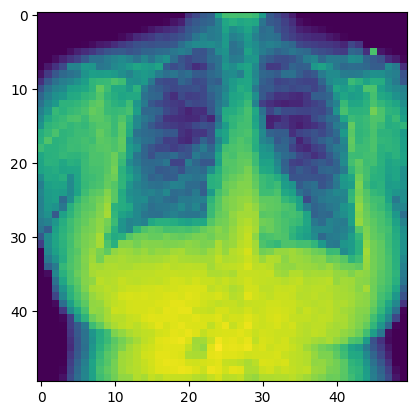

In [165]:
plt.imshow(X_train[0])

In [166]:
X_train

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.1372549 ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.18431373],
         [0.03137255],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.21960784],
         [0.05882353],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [168]:
# Build CNN model
model = keras.models.Sequential([
    # 1st Conv Layer
    keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(w, h, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(classes), activation='softmax')  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit( X_train, y_train, epochs=15, batch_size=30)


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.1842 - loss: 1.7832
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.2642 - loss: 1.7148
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.3084 - loss: 1.6580
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.3358 - loss: 1.6064
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.3805 - loss: 1.5222
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4277 - loss: 1.4308
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4752 - loss: 1.3147
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5192 - loss: 1.1951
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5548 - loss: 1.1155
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5774 - loss: 1.0444
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6049 - loss: 0.9723
Epoch 12/15
396/396 ━━━━━━━━━━

In [169]:
model.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5422 - loss: 1.2191


[1.1999731063842773, 0.555405855178833]

### Data Augmentation to Handle Overfitting 🌟

In [174]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"), 
    keras.layers.RandomRotation(0.1)
])

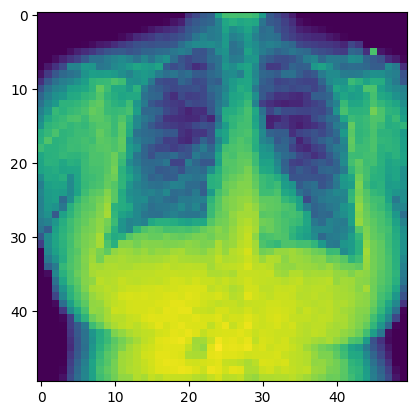

In [175]:
plt.imshow(X_train[0])

In [176]:
img_aug = data_augmentation(X_train)

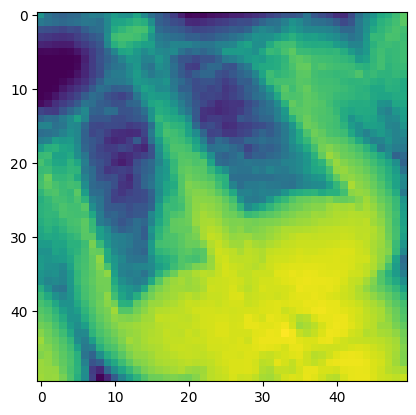

In [177]:
plt.imshow(img_aug[0])

In [178]:
# Build CNN model
model_aug = keras.models.Sequential([
    data_augmentation,
    # 1st Conv Layer
    keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(w, h, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation='softmax')  # Output layer
])

# Compile model
model_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model_aug.fit( X_train, y_train, epochs=15, batch_size=30)


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.1829 - loss: 1.7867
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2490 - loss: 1.7259
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2673 - loss: 1.7103
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2855 - loss: 1.6939
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2833 - loss: 1.6888
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2868 - loss: 1.6747
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2977 - loss: 1.6700
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3037 - loss: 1.6594
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3158 - loss: 1.6561
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.3132 - loss: 1.6437
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.3181 - loss: 1.6396
Epoch 12/15
396/396 ━━━━━━━━━━

In [179]:
model_aug.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3332 - loss: 1.6402


[1.6208271980285645, 0.3384978175163269]

In [180]:
data_augmentation_v2 = keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])

In [181]:
# Build CNN model
model_aug_v2 = keras.models.Sequential([
    data_augmentation_v2,
    # 1st Conv Layer
    keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(w, h, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation='softmax')  # Output layer
])

# Compile model
model_aug_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model_aug_v2.fit( X_train, y_train, epochs=15, batch_size=30)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.2023 - loss: 1.7776
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2581 - loss: 1.7161
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2813 - loss: 1.6827
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.2968 - loss: 1.6616
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.3140 - loss: 1.6459
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.3414 - loss: 1.6097
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.3379 - loss: 1.5946
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3591 - loss: 1.5685
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3802 - loss: 1.5206
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4032 - loss: 1.4793
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4237 - loss: 1.4251
Epoch 12/15
396/396 ━━━━━━━━━━

In [182]:
model_aug_v2.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4546 - loss: 1.3571


[1.3220657110214233, 0.4732232987880707]

In [183]:
# Build CNN model
model_v2 = keras.models.Sequential([
    # 1st Conv Layer
    keras.layers.Conv2D(50, (3, 3), activation='relu', input_shape=(w, h, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    keras.layers.Conv2D(100, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    keras.layers.Conv2D(50, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(classes), activation='softmax')  # Output layer
])

# Compile model
model_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model_v2.fit( X_train, y_train, epochs=15, batch_size=30)


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.1860 - loss: 1.7864
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.2461 - loss: 1.7257
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.2867 - loss: 1.6802
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.3193 - loss: 1.6475
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.3544 - loss: 1.5802
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.3844 - loss: 1.5171
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.4253 - loss: 1.4380
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.4564 - loss: 1.3452
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.4925 - loss: 1.2605
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.5309 - loss: 1.1823
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.5508 - loss: 1.1081
Epoch 12/15
396/396 ━━━━━━━━━━

In [184]:
model_v2.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5186 - loss: 1.2072


[1.187172770500183, 0.529471218585968]

In [108]:
# Build CNN model
model_v3 = keras.models.Sequential([
    # 1st Conv Layer
    keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(124, 124, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')  # Output layer
])

# Compile model
model_v3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model_v3.fit( X_train, y_train, epochs=15, batch_size=30)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 159s 398ms/step - accuracy: 0.1852 - loss: 1.7915
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 160s 404ms/step - accuracy: 0.2478 - loss: 1.7352
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 159s 401ms/step - accuracy: 0.2793 - loss: 1.6960
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 203s 404ms/step - accuracy: 0.3251 - loss: 1.6339
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 161s 405ms/step - accuracy: 0.3684 - loss: 1.5474
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 155s 392ms/step - accuracy: 0.4081 - loss: 1.4268
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 150s 378ms/step - accuracy: 0.4556 - loss: 1.3061
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 149s 375ms/step - accuracy: 0.5033 - loss: 1.1917
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 149s 377ms/step - accuracy: 0.5340 - loss: 1.1179
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 149s 376ms/step - accuracy: 0.5672 - loss: 1.0244
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 152s 383ms/step - accuracy: 0.5905 - loss: 0.9719
Epoch 12

In [109]:
model_v3.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5383 - loss: 1.2854


[1.2781217098236084, 0.5395756363868713]

In [ ]:
# Predict class probabilities
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred)

# Convert one-hot encoded true labels to class indices (if needed)
y_true_classes = np.argmax(y_test, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step


### KMeans Cluster

In [218]:
X_train, X_test, y_train, y_test = split_1D_data(X, y)

X_train

array([[0.        , 0.        , 0.        , ..., 0.21960784, 0.05882353,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07058824, 0.17254902, 0.08627451, ..., 0.02745098, 0.06666667,
        0.16470588],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27058824, 0.06666667,
        0.        ],
       [0.21568627, 0.        , 0.00784314, ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.83529412, 0.70980392, 0.40392157, ..., 0.06666667, 0.08235294,
        0.08235294]])

In [221]:
# Lets evaluate the within cluster sum of square using KMeans
# Simple, fast, and works well for spherical clusters.

def calculate_wcss(init, x_train, n_clusters_range=(1, 15)):
    wcss = []
    for n in range(*n_clusters_range):
        kmeans = KMeans(n_clusters=n, init=init, random_state=42)
        kmeans.fit(x_train)
        wcss.append(kmeans.inertia_)
    return wcss

wcss_Kplus = calculate_wcss('k-means++', X_train)
wcss_rand = calculate_wcss('random', X_train)

In [222]:
wcss_Kplus

[1017114.2365129294,
 824034.2002931987,
 757713.0716707008,
 726320.8848380554,
 698204.1779999766,
 676108.457316384,
 656471.0644182261,
 642853.811902645,
 629984.2111547778,
 620257.405057688,
 609593.5862714776,
 603191.337125242,
 597518.2462500875,
 590484.2353620571]

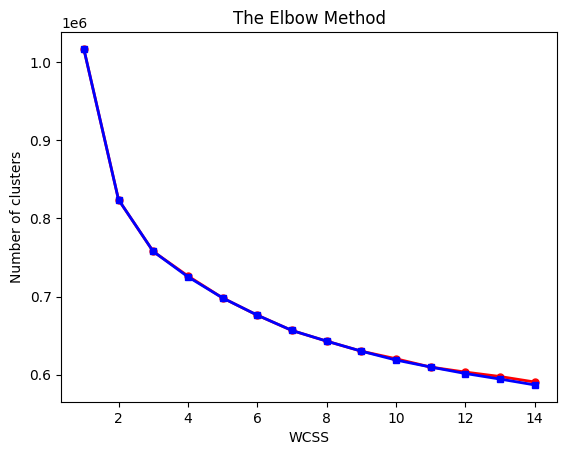

In [223]:
# Plot the graph of within sum of cluster usinf KMean++ and random
# The abrupt change was visible on  K = 2

plt.plot(range(1, 15), wcss_Kplus, 'o-r', label='KMeans++', linewidth=2, markersize=5)
plt.plot(range(1, 15), wcss_rand, 's-b', label='Random', linewidth=2, markersize=5)
plt.title('The Elbow Method')
plt.xlabel('WCSS')
plt.ylabel('Number of clusters');

For n_clusters = 2, Silhouette Score = 0.182
For n_clusters = 3, Silhouette Score = 0.112
For n_clusters = 4, Silhouette Score = 0.095
For n_clusters = 5, Silhouette Score = 0.098
For n_clusters = 6, Silhouette Score = 0.099
For n_clusters = 7, Silhouette Score = 0.084
For n_clusters = 8, Silhouette Score = 0.080
For n_clusters = 9, Silhouette Score = 0.076


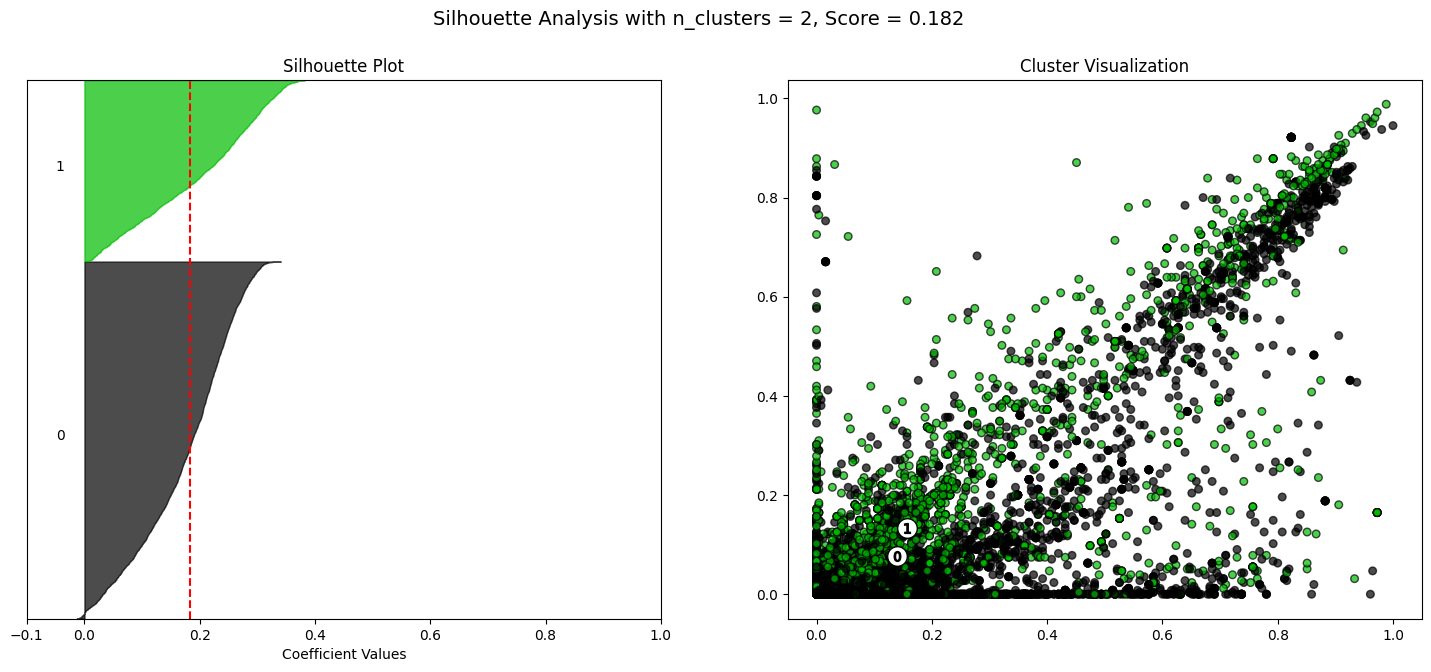

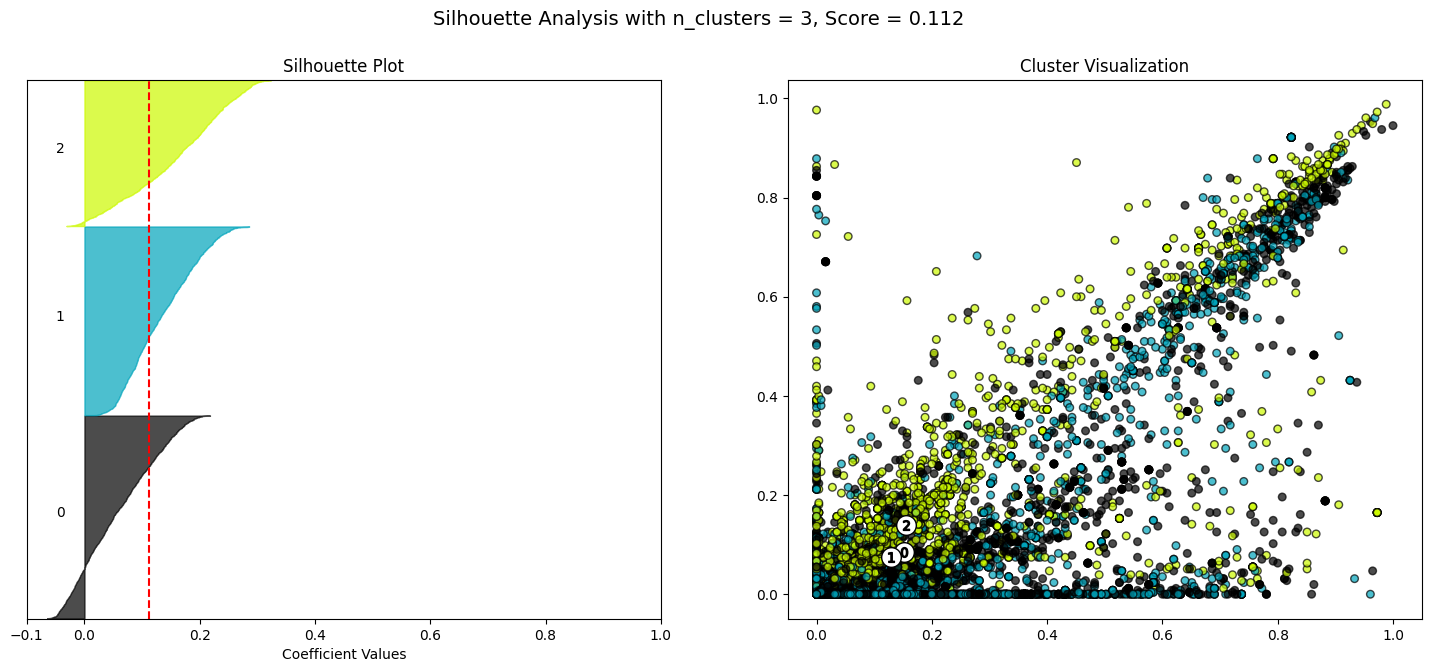

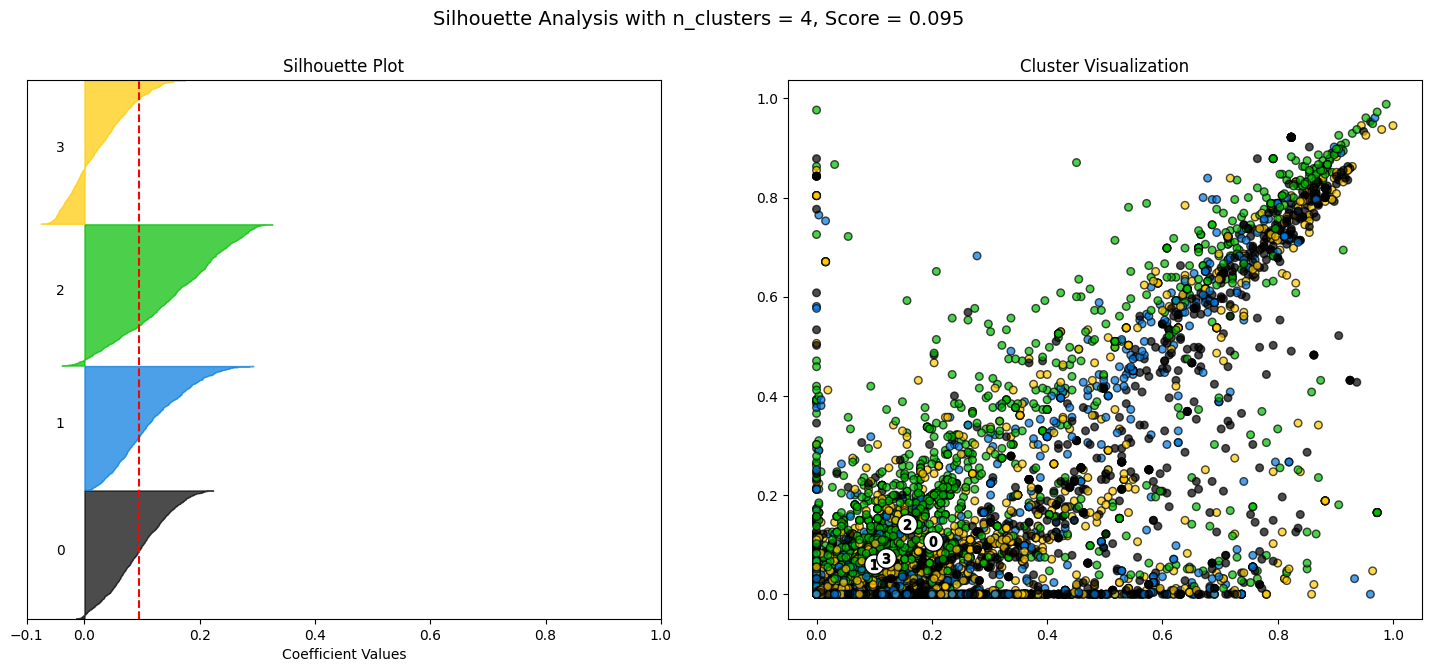

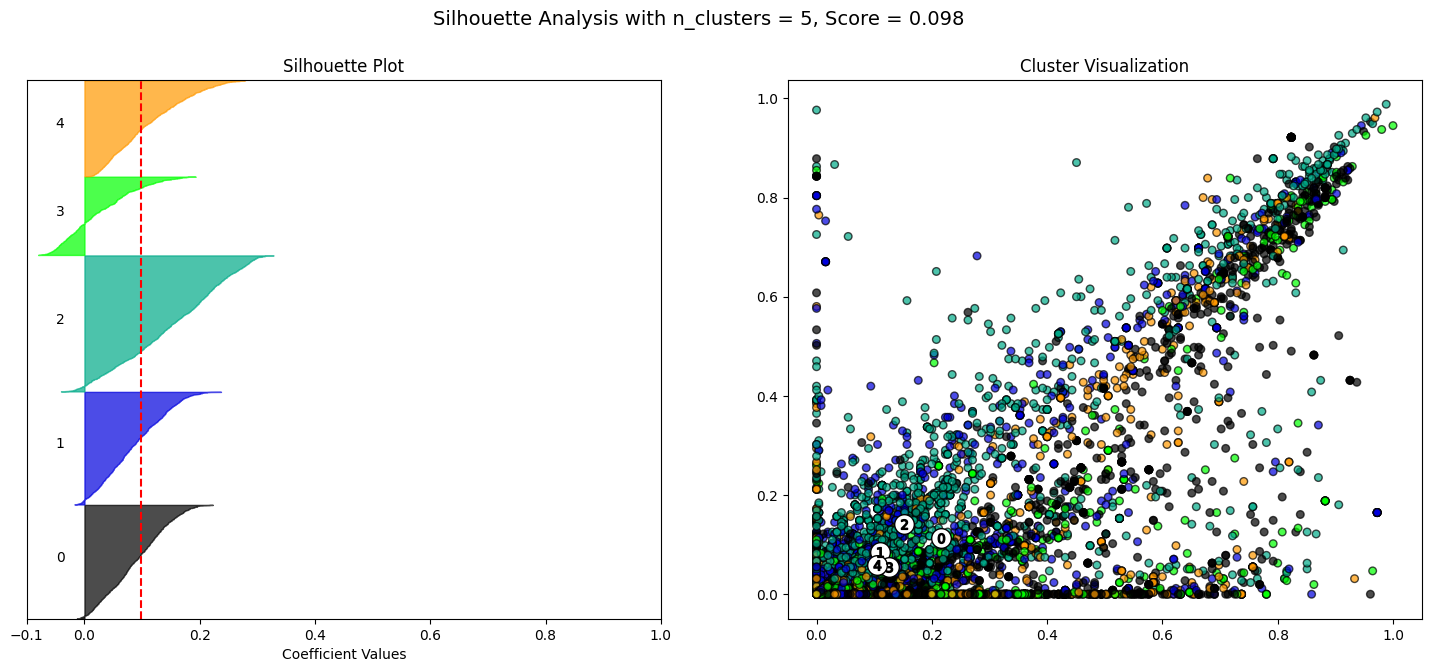

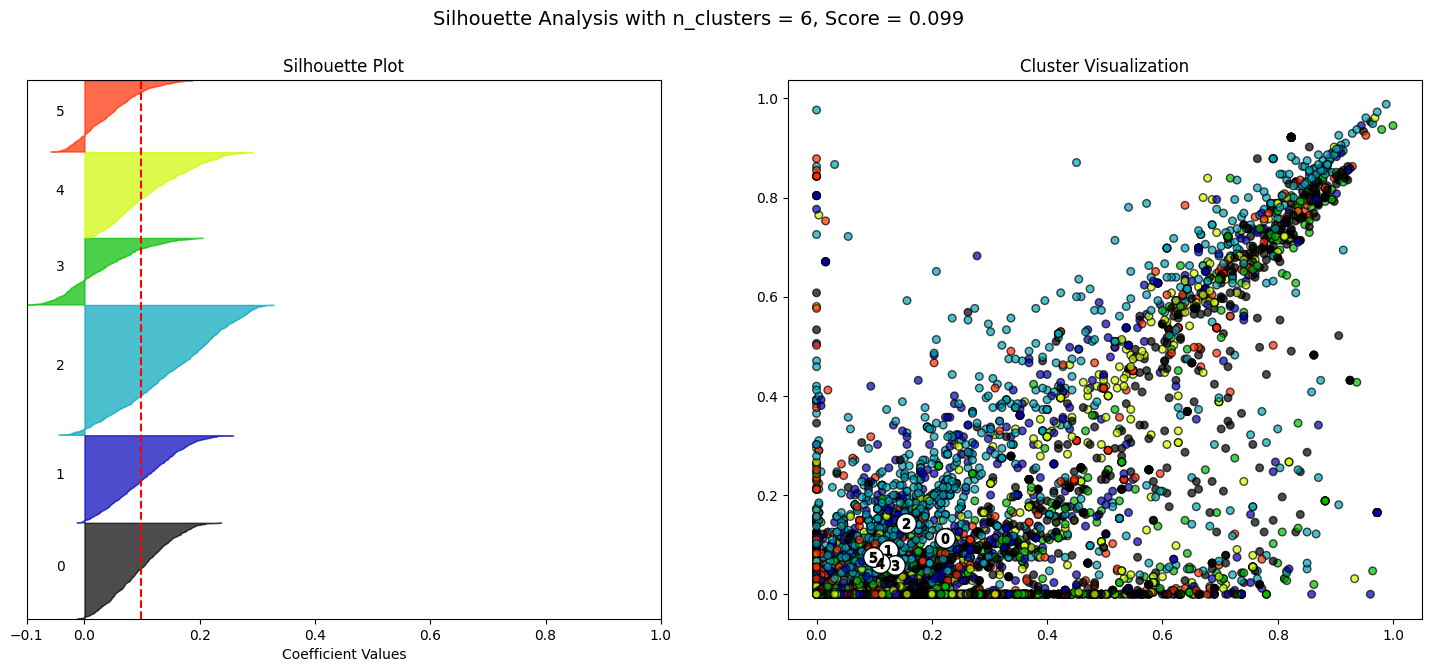

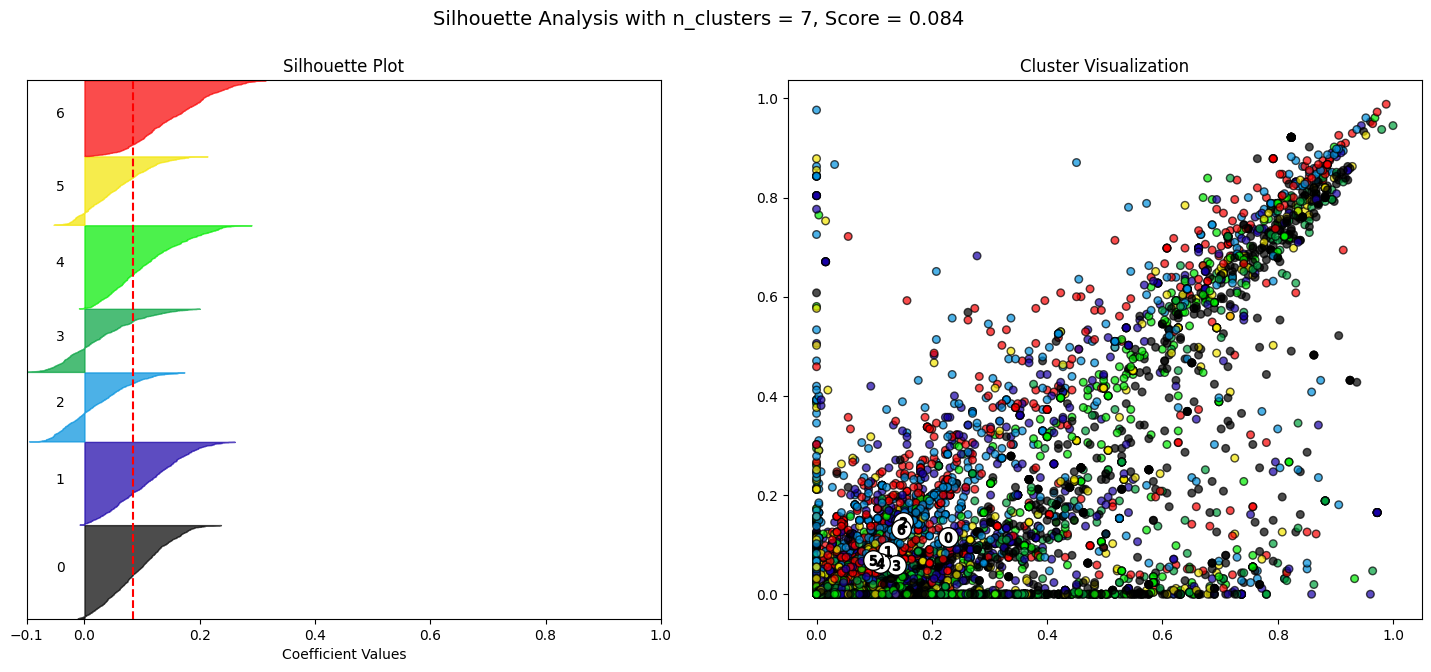

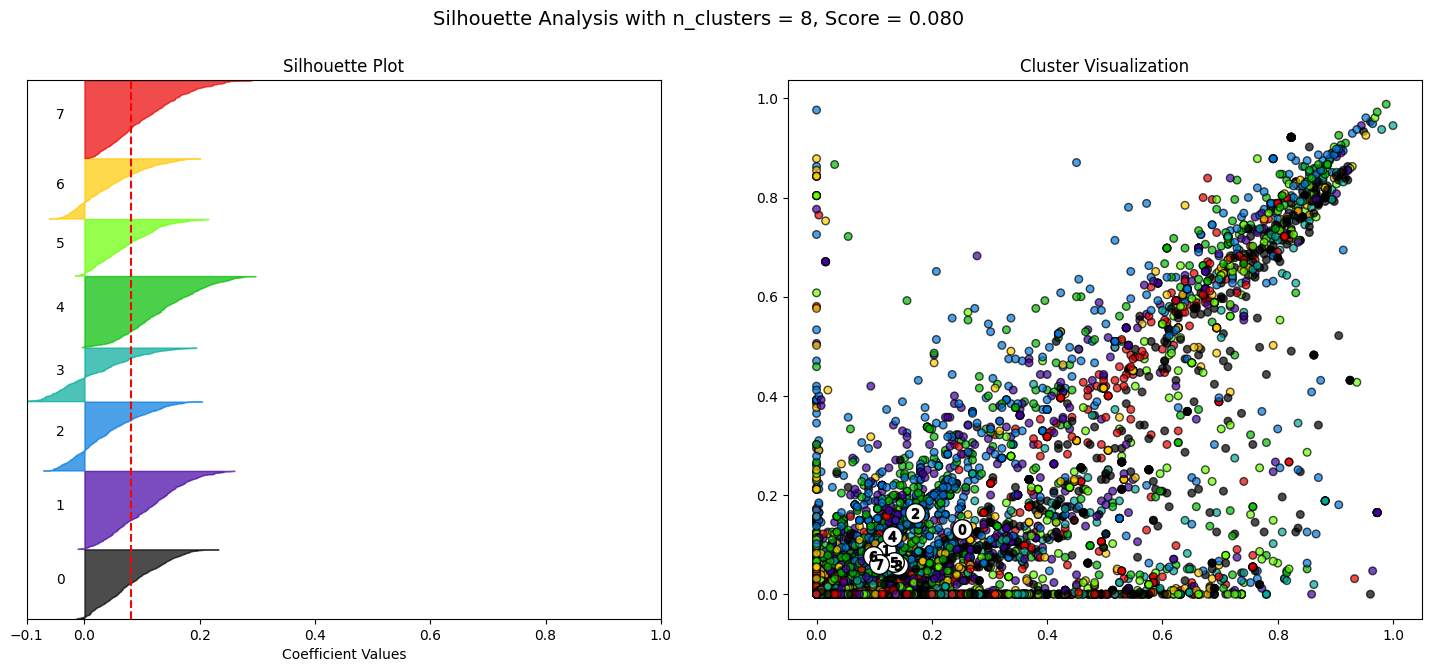

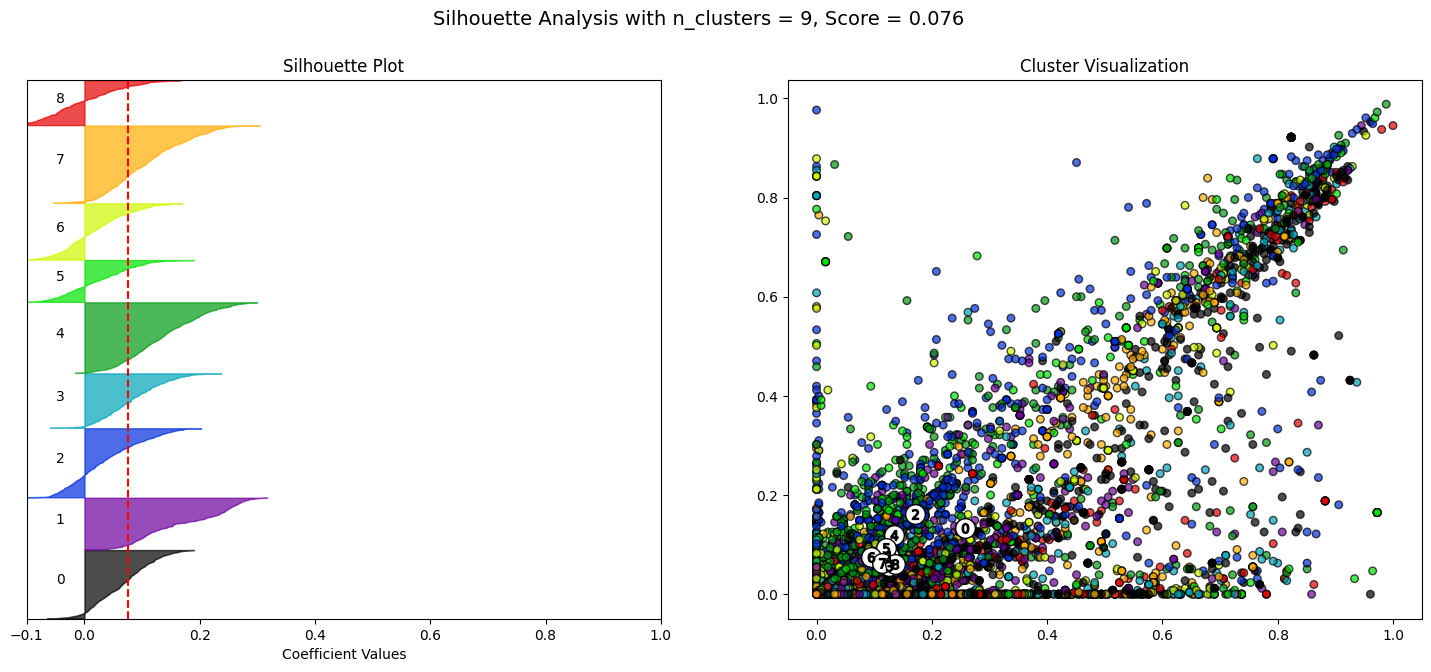

In [224]:
# Plot silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples

for clusters in range(2, 10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train) + (clusters + 1) * 10])

    model = KMeans(n_clusters=clusters, random_state=10)
    labels = model.fit_predict(X_train)

    avg_silhouette = silhouette_score(X_train, labels)
    print(f"For n_clusters = {clusters}, Silhouette Score = {avg_silhouette:.3f}")

    sample_scores = silhouette_samples(X_train, labels)
    y_lower = 10

    for i in range(clusters):
        cluster_scores = np.sort(sample_scores[labels == i])
        size = cluster_scores.shape[0]
        y_upper = y_lower + size

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper), 0, cluster_scores, facecolor=color, edgecolor=color, alpha=0.7
        )
        ax1.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=avg_silhouette, color="red", linestyle="--")
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Coefficient Values")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(labels.astype(float) / clusters)
    ax2.scatter(X_train[:, 0], X_train[:, 1], s=30, c=colors, alpha=0.7, edgecolor="k")

    centers = model.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], c="white", s=200, edgecolor="k")

    for i, center in enumerate(centers):
        ax2.scatter(center[0], center[1], marker=f"${i}$", s=50, edgecolor="k")

    ax2.set_title("Cluster Visualization")

    plt.suptitle(f"Silhouette Analysis with n_clusters = {clusters}, Score = {avg_silhouette:.3f} ", fontsize=14)

plt.show()


## SVM

In [225]:
X_train, X_test, y_train, y_test = split_1D_data(X, y)

X_train

array([[0.        , 0.        , 0.        , ..., 0.21960784, 0.05882353,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07058824, 0.17254902, 0.08627451, ..., 0.02745098, 0.06666667,
        0.16470588],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27058824, 0.06666667,
        0.        ],
       [0.21568627, 0.        , 0.00784314, ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.83529412, 0.70980392, 0.40392157, ..., 0.06666667, 0.08235294,
        0.08235294]])

In [226]:
# Computing the best hyperparameters for SVC
from sklearn.svm import SVC

svc_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svc_search = GridSearchCV(SVC(), svc_params, cv=4, n_jobs=-1)
svc_search.fit(X_train, y_train)

svc_search.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
!pip install xgboost
# Computing the best hyperparameters for XGBClassifier
from xgboost import XGBClassifier

xgboost_params = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgboost_search = GridSearchCV(XGBClassifier(), xgboost_params, cv=4, n_jobs=-1)
xgboost_search.fit(X_train, y_train)

xgboost_search.best_params_

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 2.5 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 2.2 MB/s eta 0:00:0000:0100:02


/home/evan-linux/Desktop/Deep Learning/course work/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
